## Research Question 2: Does Reddit sentiment correlate with Bitcoin volatility in short time intervals? 


#### Hypothesis: Increasing negative sentiment leads to increased volatility
- Compute negative sentiment score
- Correlation + regression 


#### Hypothesis: Increasing in hype-related keywords predicts positive returns. 
- Count hype keywords per day
- Regress next day return on the keywords count

## Import librairies

In [1]:
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.formula.api as smf
import html
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [ ]:
#load bitcoin data
bitcoin = pd.read_csv("data/btc_2018_2019.csv")
print(bitcoin.head())


                    timestamp      open      high       low     close  \
0  2018-01-01T00:00:00.000000  13840.53  13840.53  13819.04  13820.96   
1  2018-01-01T00:01:00.000000  13821.05  13888.90  13821.05  13850.67   
2  2018-01-01T00:02:00.000000  13888.91  13938.63  13850.01  13850.40   
3  2018-01-01T00:03:00.000000  13850.40  13933.94  13850.40  13894.25   
4  2018-01-01T00:04:00.000000  13894.26  13978.24  13879.83  13880.45   

      volume  
0   1.045522  
1  18.083867  
2   3.553685  
3   0.894357  
4  11.214208  


In [ ]:
#load reddit data
# First 4 are for training, 5th for validation, 6th for testing
train1 = pd.read_csv("data/reddit_translated/reddit_1.csv")
train1 = train1.drop(columns= "text") #only keep the english text, so column text_en

train2 = pd.read_csv("data/reddit_translated/reddit_2.csv")
train2 = train2.drop(columns= "text")

train3 = pd.read_csv("data/reddit_translated/reddit_3.csv")
train3 = train3.drop(columns= "text")

train4 = pd.read_csv("data/reddit_translated/reddit_4.csv")
train4 = train4.drop(columns= "text")

validate = pd.read_csv("data/reddit_translated/reddit_5.csv")
validate = validate.drop(columns= "text")

test = pd.read_csv("data/reddit_translated/reddit_6.csv")
test = test.drop(columns= "text")

print("Loaded datasets:")
print(f"train1: {len(train1)} rows")
print(f"train2: {len(train2)} rows")
print(f"train3: {len(train3)} rows")
print(f"train4: {len(train4)} rows")
print(f"validate: {len(validate)} rows")
print(f"test: {len(test)} rows")
print("\nSample from train1:")
print(train1.head())

Loaded datasets:
train1: 292404 rows
train2: 162244 rows
train3: 130209 rows
train4: 109912 rows
validate: 86329 rows
test: 108976 rows

Sample from train1:
                    timestamp  \
0  2018-01-01T00:00:14.000000   
1  2018-01-01T00:00:29.000000   
2  2018-01-01T00:00:36.000000   
3  2018-01-01T00:00:58.000000   
4  2018-01-01T00:01:10.000000   

                                             text_en  
0  Bcash isn't out yet. It's called "a new crypto...  
1  "it's instability is what makes it worthwhi-"\...  
2  It definitely will be minimum 3x BTG value onc...  
3  it is FAR superior. Litecoin is my 'everyday' ...  
4  Not really. It uses persistent accounts. The b...  


## Reddit sentiment

In [ ]:
# Function to process sentiment for a single reddit dataset
def process_reddit_sentiment(df):
    """
    Process sentiment analysis for a reddit dataframe
    """
    # Parse timestamp
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    
    # Clean text
    df["text_en"] = df["text_en"].astype(str)
    df["text_en"] = df["text_en"].apply(html.unescape)  # fix &gt; etc
    df["text_en"] = df["text_en"].str.lower()
    
    # Sentiment with vader
    analyzer = SentimentIntensityAnalyzer()
    
    def get_sentiment_scores(text):
        s = analyzer.polarity_scores(text)
        return pd.Series({
            "compound": s["compound"],
            "neg": s["neg"],
            "pos": s["pos"],
            "neu": s["neu"]
        })
    
    # Apply sentiment analysis (only call once per text)
    sentiment_scores = df["text_en"].apply(get_sentiment_scores)
    df["compound"] = sentiment_scores["compound"]
    df["neg"] = sentiment_scores["neg"]
    df["pos"] = sentiment_scores["pos"]
    df["neu"] = sentiment_scores["neu"]
    
    # Extract minute-level timestamp for merging (round down to minute)
    df["minute"] = df["timestamp"].dt.floor("min")
    
    return df

# Process all reddit datasets
print("Processing train1...")
train1_processed = process_reddit_sentiment(train1)

print("Processing train2...")
train2_processed = process_reddit_sentiment(train2)

print("Processing train3...")
train3_processed = process_reddit_sentiment(train3)

print("Processing train4...")
train4_processed = process_reddit_sentiment(train4)

print("Processing validate...")
validate_processed = process_reddit_sentiment(validate)

print("Processing test...")
test_processed = process_reddit_sentiment(test)

print("\nProcessed datasets:")
print(f"train1: {len(train1_processed)} comments")
print(f"train2: {len(train2_processed)} comments")
print(f"train3: {len(train3_processed)} comments")
print(f"train4: {len(train4_processed)} comments")
print(f"validate: {len(validate_processed)} comments")
print(f"test: {len(test_processed)} comments")
print("\nSample from train1_processed:")
print(train1_processed.head())

Processing train1...
Processing train2...
Processing train3...
Processing train4...
Processing validate...
Processing test...

Processed datasets:
train1: 292404 comments
train2: 162244 comments
train3: 130209 comments
train4: 109912 comments
validate: 86329 comments
test: 108976 comments

Sample from train1_processed:
            timestamp                                            text_en  \
0 2018-01-01 00:00:14  bcash isn't out yet. it's called "a new crypto...   
1 2018-01-01 00:00:29  "it's instability is what makes it worthwhi-"\...   
2 2018-01-01 00:00:36  it definitely will be minimum 3x btg value onc...   
3 2018-01-01 00:00:58  it is far superior. litecoin is my 'everyday' ...   
4 2018-01-01 00:01:10  not really. it uses persistent accounts. the b...   

   compound    neg    pos    neu              minute  
0    0.0000  0.000  0.000  1.000 2018-01-01 00:00:00  
1   -0.8228  0.153  0.000  0.847 2018-01-01 00:00:00  
2    0.8908  0.034  0.228  0.739 2018-01-01 00:00:00  
3 

In [14]:
# Save processed datasets
print("\nSaving processed datasets...")
train1_processed.to_csv("data/train1_processed.csv", index=False)
train2_processed.to_csv("data/train2_processed.csv", index=False)
train3_processed.to_csv("data/train3_processed.csv", index=False)
train4_processed.to_csv("data/train4_processed.csv", index=False)
validate_processed.to_csv("data/validate_processed.csv", index=False)
test_processed.to_csv("data/test_processed.csv", index=False)
print("All processed datasets saved!")


Saving processed datasets...
All processed datasets saved!


In [15]:
# Aggregate reddit sentiment by minute for each dataset
def aggregate_by_minute(df, name):
    """Aggregate sentiment by minute"""
    reddit_minute = df.groupby("minute").agg({
        "compound": ["mean", "std", "count"],
        "neg": "mean",
        "pos": "mean",
        "neu": "mean"
    }).reset_index()
    
    # Flatten column names
    reddit_minute.columns = ["minute", "mean_sent", "std_sent", "count_sent", "mean_neg", "mean_pos", "mean_neu"]
    
    print(f"{name}: {len(reddit_minute)} unique minutes")
    return reddit_minute

print("Aggregating sentiment by minute...")
train1_minute = aggregate_by_minute(train1_processed, "train1")
train2_minute = aggregate_by_minute(train2_processed, "train2")
train3_minute = aggregate_by_minute(train3_processed, "train3")
train4_minute = aggregate_by_minute(train4_processed, "train4")
validate_minute = aggregate_by_minute(validate_processed, "validate")
test_minute = aggregate_by_minute(test_processed, "test")

print("\nSample from train1_minute:")
print(train1_minute.head())

Aggregating sentiment by minute...
train1: 81372 unique minutes
train2: 70780 unique minutes
train3: 64971 unique minutes
train4: 60558 unique minutes
validate: 53216 unique minutes
test: 59326 unique minutes

Sample from train1_minute:
               minute  mean_sent  std_sent  count_sent  mean_neg  mean_pos  \
0 2018-01-01 00:00:00   0.208125  0.791985           4  0.046750   0.11275   
1 2018-01-01 00:01:00  -0.019250  0.532122           4  0.024750   0.02675   
2 2018-01-01 00:02:00   0.064813  0.590131           8  0.063625   0.08450   
3 2018-01-01 00:03:00   0.612500  0.188273           3  0.042667   0.16000   
4 2018-01-01 00:04:00   0.369150  0.072054           2  0.028500   0.07100   

   mean_neu  
0  0.840750  
1  0.948500  
2  0.852000  
3  0.797333  
4  0.900000  


In [16]:
# Process bitcoin data (already at minute level, just parse timestamp)
print("Processing bitcoin data...")
bitcoin["timestamp"] = pd.to_datetime(bitcoin["timestamp"], errors="coerce")
bitcoin = bitcoin.dropna(subset=["timestamp"])
bitcoin["minute"] = bitcoin["timestamp"].dt.floor("min")

# Bitcoin is already at minute level, so we can use it directly
# But if there are multiple rows per minute, aggregate them
btc_minute = bitcoin.groupby("minute").agg({
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}).reset_index()

print(f"Total minutes with bitcoin data: {len(btc_minute)}")
print(f"Date range: {btc_minute['minute'].min()} to {btc_minute['minute'].max()}")


print(btc_minute.head())

Processing bitcoin data...
Total minutes with bitcoin data: 525600
Date range: 2018-01-01 00:00:00 to 2018-12-31 23:59:00
               minute      open      high       low     close     volume
0 2018-01-01 00:00:00  13840.53  13840.53  13819.04  13820.96   1.045522
1 2018-01-01 00:01:00  13821.05  13888.90  13821.05  13850.67  18.083867
2 2018-01-01 00:02:00  13888.91  13938.63  13850.01  13850.40   3.553685
3 2018-01-01 00:03:00  13850.40  13933.94  13850.40  13894.25   0.894357
4 2018-01-01 00:04:00  13894.26  13978.24  13879.83  13880.45  11.214208


In [ ]:
# Merge each reddit dataset with bitcoin data by minute
def merge_with_bitcoin(reddit_df, btc_df, name):
    """Merge reddit sentiment with bitcoin data by minute"""
    merged = pd.merge(btc_df, reddit_df, on="minute", how="inner")
    merged = merged.sort_values("minute").reset_index(drop=True)
    return merged

print("Merging datasets with bitcoin data...")
train1_merged = merge_with_bitcoin(train1_minute, btc_minute, "train1")
train2_merged = merge_with_bitcoin(train2_minute, btc_minute, "train2")
train3_merged = merge_with_bitcoin(train3_minute, btc_minute, "train3")
train4_merged = merge_with_bitcoin(train4_minute, btc_minute, "train4")
validate_merged = merge_with_bitcoin(validate_minute, btc_minute, "validate")
test_merged = merge_with_bitcoin(test_minute, btc_minute, "test")

print("\nMerged datasets:")
print(f"train1_merged: {len(train1_merged)} rows")
print(f"train2_merged: {len(train2_merged)} rows")
print(f"train3_merged: {len(train3_merged)} rows")
print(f"train4_merged: {len(train4_merged)} rows")
print(f"validate_merged: {len(validate_merged)} rows")
print(f"test_merged: {len(test_merged)} rows")

# Save each merged dataset
print("\nSaving merged datasets...")
train1_merged.to_csv("data/train1_merged.csv", index=False)
train2_merged.to_csv("data/train2_merged.csv", index=False)
train3_merged.to_csv("data/train3_merged.csv", index=False)
train4_merged.to_csv("data/train4_merged.csv", index=False)
validate_merged.to_csv("data/validate_merged.csv", index=False)
test_merged.to_csv("data/test_merged.csv", index=False)
print("All merged datasets saved to CSV files!")
print("\nSample from train1_merged:")
print(train1_merged.head())
print("\nColumn names:")
print(train1_merged.columns.tolist())

Merging datasets with bitcoin data...

Merged datasets:
train1_merged: 81372 rows
train2_merged: 70780 rows
train3_merged: 64971 rows
train4_merged: 60558 rows
validate_merged: 53216 rows
test_merged: 59326 rows

Saving merged datasets...
All merged datasets saved to CSV files!

Sample from train1_merged:
               minute      open      high       low     close     volume  \
0 2018-01-01 00:00:00  13840.53  13840.53  13819.04  13820.96   1.045522   
1 2018-01-01 00:01:00  13821.05  13888.90  13821.05  13850.67  18.083867   
2 2018-01-01 00:02:00  13888.91  13938.63  13850.01  13850.40   3.553685   
3 2018-01-01 00:03:00  13850.40  13933.94  13850.40  13894.25   0.894357   
4 2018-01-01 00:04:00  13894.26  13978.24  13879.83  13880.45  11.214208   

   mean_sent  std_sent  count_sent  mean_neg  mean_pos  mean_neu  
0   0.208125  0.791985           4  0.046750   0.11275  0.840750  
1  -0.019250  0.532122           4  0.024750   0.02675  0.948500  
2   0.064813  0.590131           8 

## Data Analysis

In [ ]:
# read the csv files instead of having to rerun the above (which took a long time)

train1_merged = pd.read_csv("../data/train1_merged.csv")
train2_merged = pd.read_csv("../data/train2_merged.csv")
train3_merged = pd.read_csv("../data/train3_merged.csv")
train4_merged = pd.read_csv("../data/train4_merged.csv")
test_merged = pd.read_csv("../data/test_merged.csv")
validate_merged = pd.read_csv("../data/validate_merged.csv")

In [4]:
# for analysis, we'll use train1_merged as an example of sample of the reddit dataset
# we can repeat this for other datasets (train2-4, validate, test)
df = train1_merged.copy()
df = df.sort_values("minute").reset_index(drop=True)

# Calculate returns and volatility
df["return"] = df["close"].pct_change()
df["volatility"] = df["return"].rolling(window=60).std() # 60 minute rolling volatility
df["price_change"] = df["close"] - df["open"]

# Basic statistics
print("Dataset Overview")
print(f"Total minutes: {len(df)}")
print(f"Date range: {df['minute'].min()} to {df['minute'].max()}")
print(f"\nSentiment Statistics")
print(df[["mean_sent", "mean_neg", "mean_pos", "mean_neu", "count_sent"]].describe())
print(f"\nBitcoin Price Statistics")
print(df[["open", "high", "low", "close", "volume", "return", "volatility"]].describe())

Dataset Overview
Total minutes: 81372
Date range: 2018-01-01 00:00:00 to 2018-03-02 19:58:00

Sentiment Statistics
          mean_sent      mean_neg      mean_pos      mean_neu    count_sent
count  81372.000000  81372.000000  81372.000000  81372.000000  81372.000000
mean       0.214908      0.061239      0.103718      0.835043      3.593423
std        0.361653      0.049173      0.060548      0.072178      2.266967
min       -0.999000      0.000000      0.000000      0.222000      1.000000
25%        0.000000      0.028667      0.066667      0.796500      2.000000
50%        0.229633      0.053845      0.097000      0.839500      3.000000
75%        0.450838      0.083635      0.132667      0.879000      5.000000
max        0.999600      0.778000      0.767000      1.000000     23.000000

Bitcoin Price Statistics
               open          high           low         close        volume  \
count  81372.000000  81372.000000  81372.000000  81372.000000  81372.000000   
mean   11273.7440

## Sentiment distribution

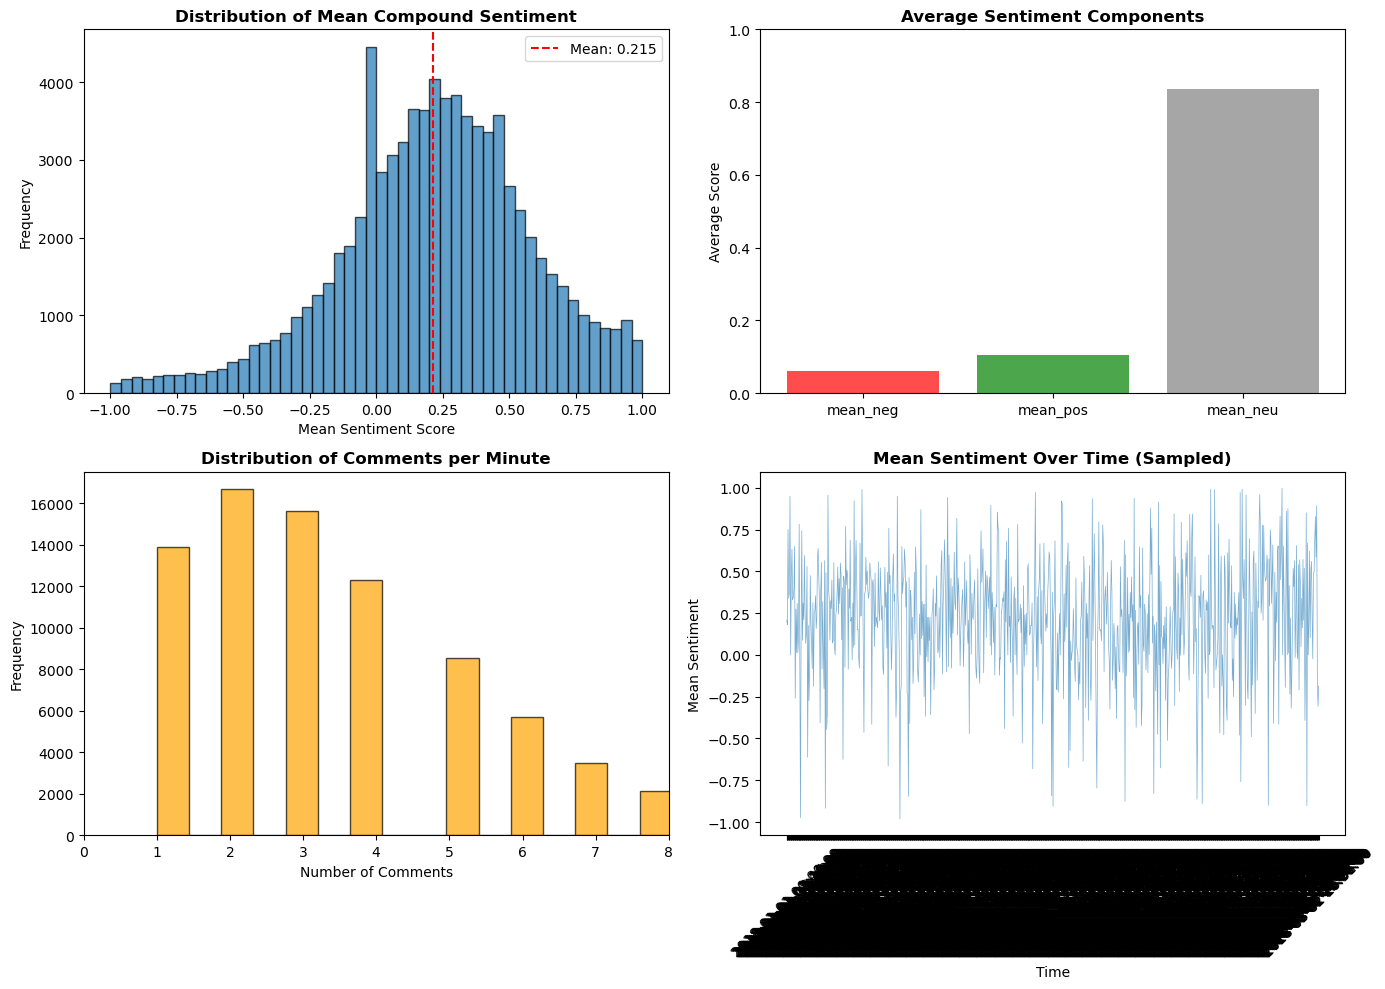

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Compound sentiment distribution
axes[0, 0].hist(df["mean_sent"].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title("Distribution of Mean Compound Sentiment", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Mean Sentiment Score")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].axvline(df["mean_sent"].mean(), color='red', linestyle='--', label=f'Mean: {df["mean_sent"].mean():.3f}')
axes[0, 0].legend()

# Sentiment components
sentiment_components = df[["mean_neg", "mean_pos", "mean_neu"]].mean()
axes[0, 1].bar(sentiment_components.index, sentiment_components.values, color=['red', 'green', 'gray'], alpha=0.7)
axes[0, 1].set_title("Average Sentiment Components", fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel("Average Score")
axes[0, 1].set_ylim(0, 1)

# Comment count per minute
axes[1, 0].hist(df["count_sent"].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title("Distribution of Comments per Minute", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Number of Comments")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].set_xlim(0, df["count_sent"].quantile(0.95))  # Remove outliers for better view

# Sentiment over time (sample)
sample_df = df.iloc[::100]  # Sample every 100th minute for performance
axes[1, 1].plot(sample_df["minute"], sample_df["mean_sent"], alpha=0.6, linewidth=0.5)
axes[1, 1].set_title("Mean Sentiment Over Time (Sampled)", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Mean Sentiment")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Interpretation:** This visualization shows the distribution of reddit sentiment at minute-level intervals. The sentiment distribution appears relatively balanced around zero, with most comments being neutral. We will now need to see if variations in this sentiment distribution correlate with Bitcoin volatility. The time series plot shows sentiment fluctuates over time, which we'll compare with volatility patterns.


## Bitcoin price and volume analysis


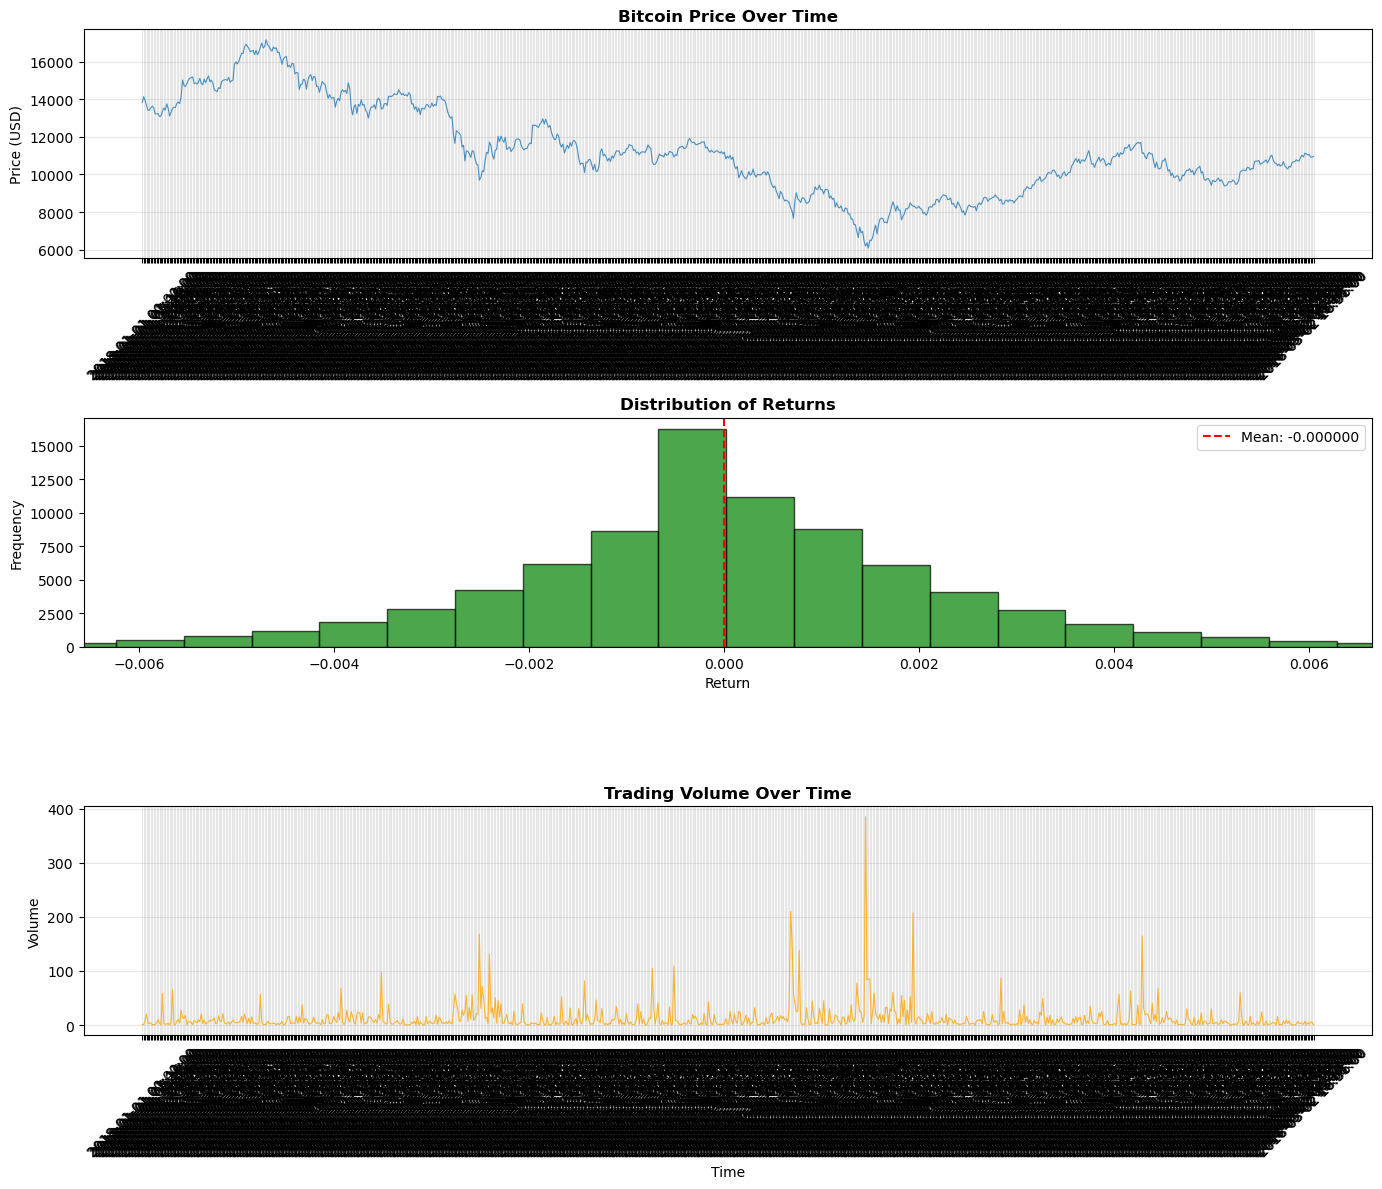

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Price over time
sample_df = df.iloc[::100] # Sample otherwise it takes far too long
axes[0].plot(sample_df["minute"], sample_df["close"], linewidth=0.8, alpha=0.8)
axes[0].set_title("Bitcoin Price Over Time", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Price (USD)")
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Returns distribution
axes[1].hist(df["return"].dropna(), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title("Distribution of Returns", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Return")
axes[1].set_ylabel("Frequency")
axes[1].axvline(df["return"].mean(), color='red', linestyle='--', label=f'Mean: {df["return"].mean():.6f}')
axes[1].legend()
axes[1].set_xlim(df["return"].quantile(0.01), df["return"].quantile(0.99))  # Remove extreme outliers

# Volume over time
axes[2].plot(sample_df["minute"], sample_df["volume"], linewidth=0.8, alpha=0.8, color='orange')
axes[2].set_title("Trading Volume Over Time", fontsize=12, fontweight='bold')
axes[2].set_xlabel("Time")
axes[2].set_ylabel("Volume")
axes[2].grid(True, alpha=0.3)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Interpretation:** The above shows Bitcoin's price movements and return distribution at minute-level intervals. The returns distribution appears centered near zero with some volatility spikes. For RQ2, we need to examine whether these volatility patterns (measured as rolling standard deviation of returns) correlate with reddit sentiment. The price and volume trends provide context for understanding market behavior during the study period.

## Sentiment vs bitcoin metrics - correlation analysis

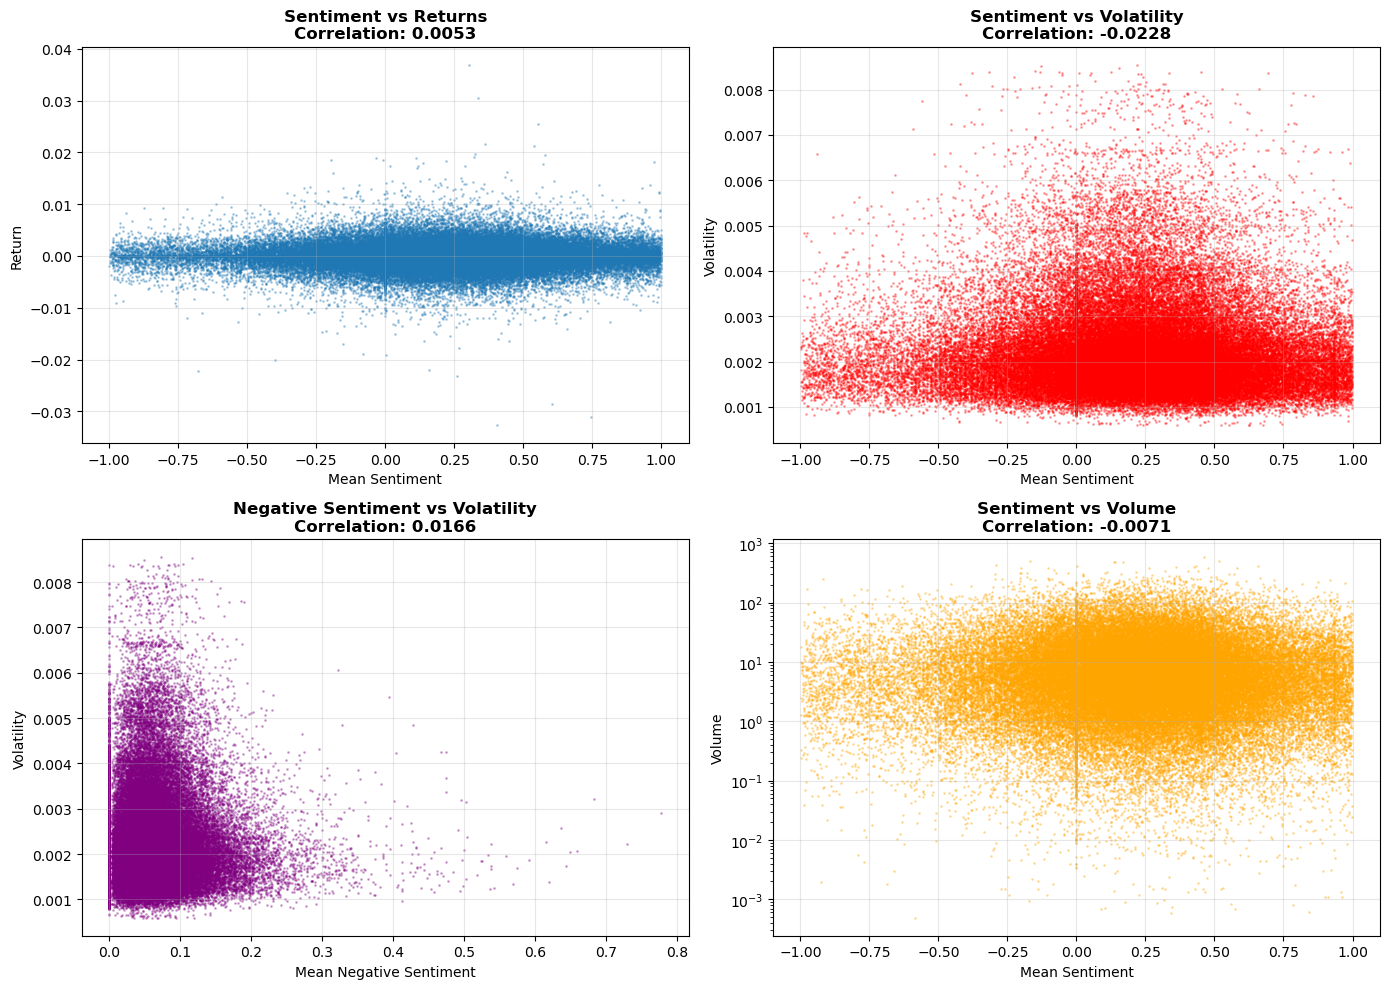

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Remove NaN values for correlation
df_clean = df[["mean_sent", "mean_neg", "return", "volatility", "volume", "close"]].dropna()

# Sentiment vs returns
axes[0, 0].scatter(df_clean["mean_sent"], df_clean["return"], alpha=0.3, s=1)
axes[0, 0].set_title(f"Sentiment vs Returns\nCorrelation: {df_clean[['mean_sent', 'return']].corr().iloc[0,1]:.4f}", 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Mean Sentiment")
axes[0, 0].set_ylabel("Return")
axes[0, 0].grid(True, alpha=0.3)

# Sentiment vs volatility
axes[0, 1].scatter(df_clean["mean_sent"], df_clean["volatility"], alpha=0.3, s=1, color='red')
axes[0, 1].set_title(f"Sentiment vs Volatility\nCorrelation: {df_clean[['mean_sent', 'volatility']].corr().iloc[0,1]:.4f}", 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Mean Sentiment")
axes[0, 1].set_ylabel("Volatility")
axes[0, 1].grid(True, alpha=0.3)

# Negative sentiment vs volatility (testing hypothesis)
axes[1, 0].scatter(df_clean["mean_neg"], df_clean["volatility"], alpha=0.3, s=1, color='purple')
axes[1, 0].set_title(f"Negative Sentiment vs Volatility\nCorrelation: {df_clean[['mean_neg', 'volatility']].corr().iloc[0,1]:.4f}", 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Mean Negative Sentiment")
axes[1, 0].set_ylabel("Volatility")
axes[1, 0].grid(True, alpha=0.3)

# Sentiment vs volume
axes[1, 1].scatter(df_clean["mean_sent"], df_clean["volume"], alpha=0.3, s=1, color='orange')
axes[1, 1].set_title(f"Sentiment vs Volume\nCorrelation: {df_clean[['mean_sent', 'volume']].corr().iloc[0,1]:.4f}", 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Mean Sentiment")
axes[1, 1].set_ylabel("Volume")
axes[1, 1].set_yscale('log') # Log scale for volume
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Interpretation:** The plots show correlations between sentiment and Bitcoin metrics at minute-level intervals. Most importantly, the sentiment vs volatility and negative sentiment vs volatility plots directly address our research question 

- Sentiment vs returns: The cloud is flat and correlations ~0.005 = no meaningful link; returns don’t move with average sentiment
- Sentiment vs volatility: correlation ~0.002 = effectively zero; volatility looks the same across all sentiment levels.
- Negative sentiment vs volatility: slightly positive correlation (~0.017) but extremely small; volatility doesn’t noticeably rise with more negative sentiment.
- Sentiment vs volume: correlation ~0.007 on a log-scale volume axis = no clear relationship; volume is spread widely for all sentiment levels.


Overall: all four plots show correlations essentially at zero—no meaningful relationship between Reddit sentiment (positive or negative) and short-interval Bitcoin returns, volatility, or volume.


## Time series comparison: sSentiment vs price/volatility

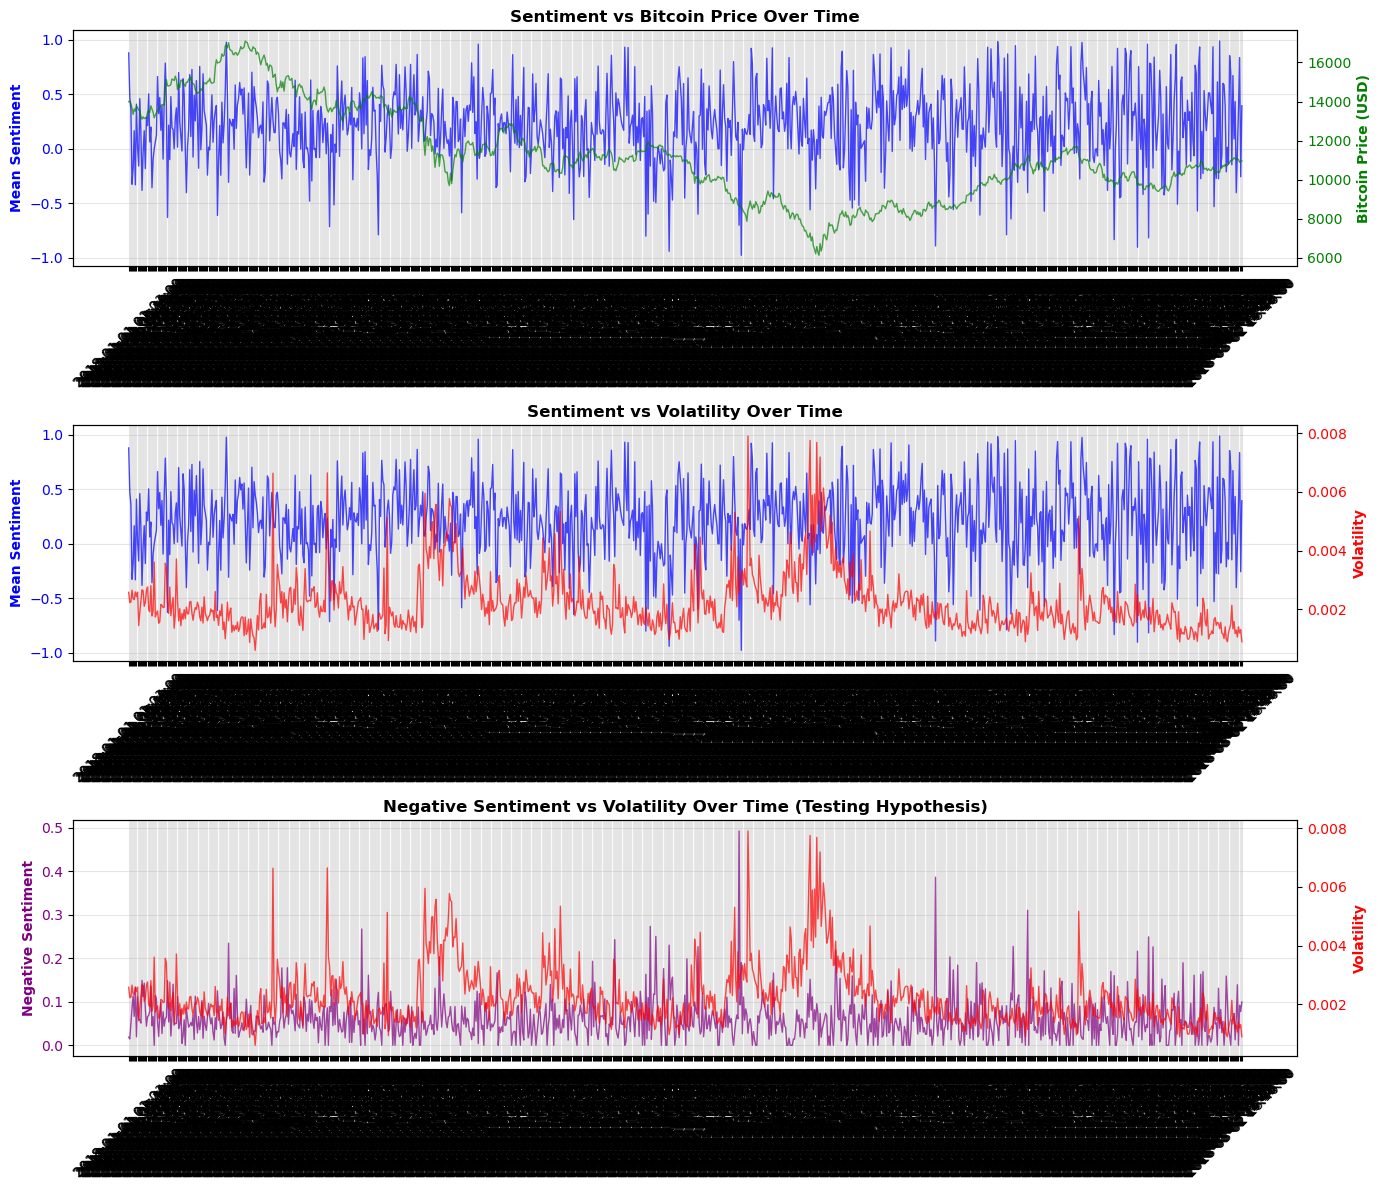

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Sample data for better performance
sample_size = 1000
sample_df = df.dropna(subset=["mean_sent", "close", "volatility"]).iloc[::max(1, len(df)//sample_size)]

# Sentiment over time
ax1 = axes[0]
ax1_twin = ax1.twinx()
line1 = ax1.plot(sample_df["minute"], sample_df["mean_sent"], color='blue', alpha=0.7, label='Mean Sentiment', linewidth=1)
line2 = ax1_twin.plot(sample_df["minute"], sample_df["close"], color='green', alpha=0.7, label='Bitcoin Price', linewidth=1)
ax1.set_ylabel("Mean Sentiment", color='blue', fontweight='bold')
ax1_twin.set_ylabel("Bitcoin Price (USD)", color='green', fontweight='bold')
ax1.set_title("Sentiment vs Bitcoin Price Over Time", fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1_twin.tick_params(axis='y', labelcolor='green')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Sentiment vs Volatility
ax2 = axes[1]
ax2_twin = ax2.twinx()
line3 = ax2.plot(sample_df["minute"], sample_df["mean_sent"], color='blue', alpha=0.7, label='Mean Sentiment', linewidth=1)
line4 = ax2_twin.plot(sample_df["minute"], sample_df["volatility"], color='red', alpha=0.7, label='Volatility', linewidth=1)
ax2.set_ylabel("Mean Sentiment", color='blue', fontweight='bold')
ax2_twin.set_ylabel("Volatility", color='red', fontweight='bold')
ax2.set_title("Sentiment vs Volatility Over Time", fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='blue')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Negative sentiment vs Volatility (testing hypothesis)
ax3 = axes[2]
ax3_twin = ax3.twinx()
line5 = ax3.plot(sample_df["minute"], sample_df["mean_neg"], color='purple', alpha=0.7, label='Negative Sentiment', linewidth=1)
line6 = ax3_twin.plot(sample_df["minute"], sample_df["volatility"], color='red', alpha=0.7, label='Volatility', linewidth=1)
ax3.set_ylabel("Negative Sentiment", color='purple', fontweight='bold')
ax3_twin.set_ylabel("Volatility", color='red', fontweight='bold')
ax3.set_title("Negative Sentiment vs Volatility Over Time (Testing Hypothesis)", fontsize=12, fontweight='bold')
ax3.tick_params(axis='y', labelcolor='purple')
ax3_twin.tick_params(axis='y', labelcolor='red')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Interpretation:** These dual-axis time series plots allow us to visually inspect whether sentiment and volatility move together over time. For RQ2, the middle and bottom plots are most relevant:

- Sentiment vs bitcoin : the blue sentiment line swings rapidly between positive and negative, while price (green, right axis) trends down mid-chart then recovers later. Their movements don’t line up,price rises and falls without matching sentiment shifts.
- Sentiment vs volatility: volatility spikes (red, right axs) happen at scattered times, but they don’t coincide with clear sentiment surges or drops. Sentiment keeps oscillating regardless of volatility level.
- Negative sentiment vs volatility: peaks in negative sentiment (purple) and volatility (red) rarely align; most volatility spikes occur when negative sentiment is low to moderate. No visible pattern of more negativity = higher volatility.

Overall: the lines move independently, no consistent timing where sentiment (or negative sentiment) rises or falls with price or volatility.

## Correlation Matrix

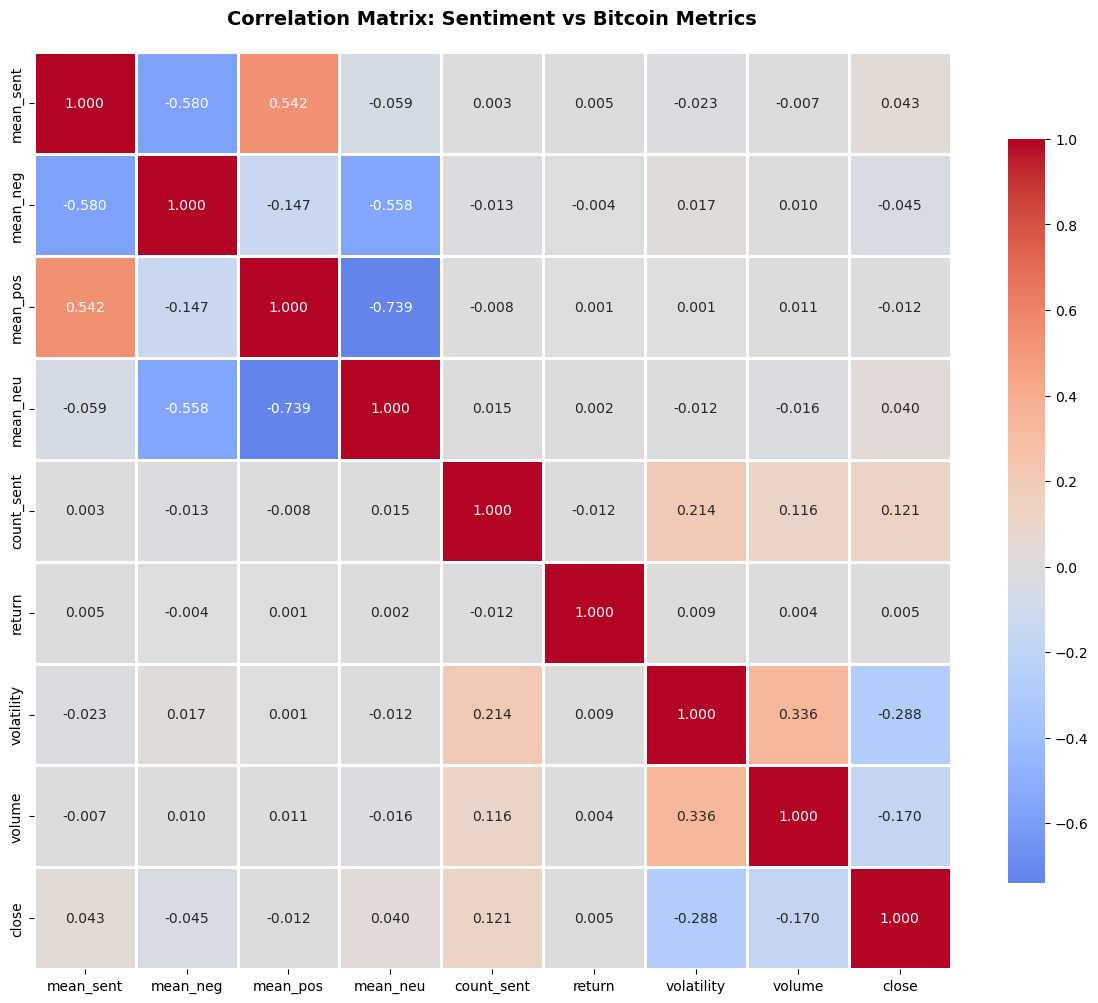

Key Correlations
Mean Sentiment vs Returns: 0.0053
Mean Sentiment vs Volatility: -0.0228
Negative Sentiment vs Volatility: 0.0166
Positive Sentiment vs Returns: 0.0007
Comment Count vs Volume: 0.1163


In [ ]:
# Select relevant columns for correlation
corr_cols = ["mean_sent", "mean_neg", "mean_pos", "mean_neu", "count_sent", 
             "return", "volatility", "volume", "close"]
corr_df = df[corr_cols].dropna()

correlation_matrix = corr_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix: Sentiment vs Bitcoin Metrics", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print key correlations
print("Key Correlations")
print(f"Mean Sentiment vs Returns: {corr_df[['mean_sent', 'return']].corr().iloc[0,1]:.4f}")
print(f"Mean Sentiment vs Volatility: {corr_df[['mean_sent', 'volatility']].corr().iloc[0,1]:.4f}")
print(f"Negative Sentiment vs Volatility: {corr_df[['mean_neg', 'volatility']].corr().iloc[0,1]:.4f}")
print(f"Positive Sentiment vs Returns: {corr_df[['mean_pos', 'return']].corr().iloc[0,1]:.4f}")
print(f"Comment Count vs Volume: {corr_df[['count_sent', 'volume']].corr().iloc[0,1]:.4f}")


**Interpretation:** The correlation heatmap provides a comprehensive view of all relationships. For our research question, we should focus on the row/column for "volatility" and its intersections with sentiment metrics (mean_sent, mean_neg, mean_pos). 

- Sentiment vs price/returns/volatility/volume: all near-zero (between about -0.03 and 0.04 for mean_sent with returns, volatility, volume, close), meaning sentiment isn’t linearly related to those Bitcoin metrics.
- Sentiment counts vs market metrics: count of sentiment posts has weak positive ties to volatility (0.214) and volume (0.116), still small; little to no relation to returns/price.


## Statistical analysis: regression models

Negative Sentiment vs Volatility
                            OLS Regression Results                            
Dep. Variable:             volatility   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     22.47
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           2.14e-06
Time:                        10:37:10   Log-Likelihood:             4.4884e+05
No. Observations:               81312   AIC:                        -8.977e+05
Df Residuals:                   81310   BIC:                        -8.977e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.00

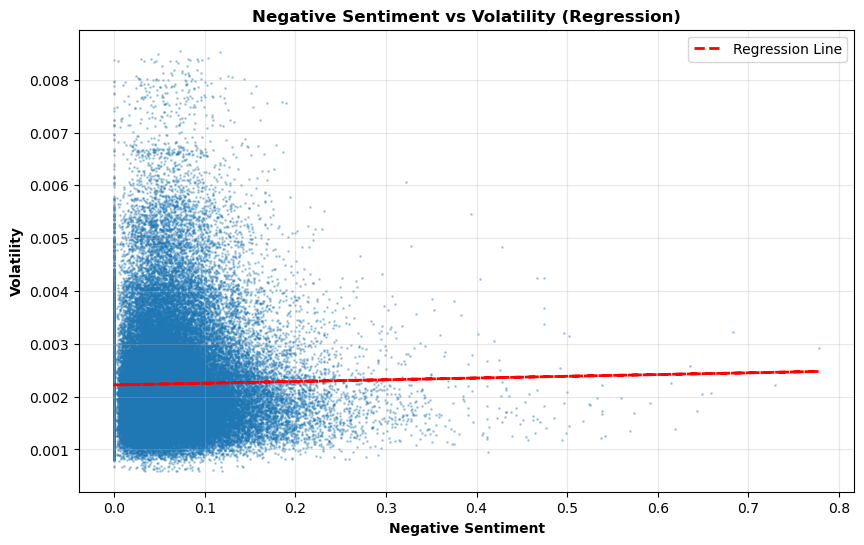

In [10]:
# Negative sentiment predicting volatility (testing hypothesis)
print("Negative Sentiment vs Volatility")
df_reg = df[["mean_neg", "volatility"]].dropna()
if len(df_reg) > 0:
    model1 = smf.ols('volatility ~ mean_neg', data=df_reg).fit()
    print(model1.summary())
    
    # Plot regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(df_reg["mean_neg"], df_reg["volatility"], alpha=0.3, s=1)
    plt.plot(df_reg["mean_neg"], model1.fittedvalues, 'r--', linewidth=2, label='Regression Line')
    plt.xlabel("Negative Sentiment", fontweight='bold')
    plt.ylabel("Volatility", fontweight='bold')
    plt.title("Negative Sentiment vs Volatility (Regression)", fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Insufficient data for regression")


**Interpretation:** The OLS regression tests whether negative sentiment significantly predicts volatility.

- R² = 0.000: The model explains essentially none of the variation in volatility.
- slope (mean_neg ≈ 0.0003) is statistically significant (p<0.001) only because the sample is huge; the magnitude is negligible—practically no effect.
- intercept ≈ 0.0022 matches the baseline volatility seen in the dense cluster.
- residual diagnostics (very low durbin-watson, JB p~0) show strong autocorrelation and non-normality, so classic OLS assumptions aren’t well met—but that doesn’t change the core takeaway: the fitted effect is vanishingly small.
- plot: almost all points sit at low negative sentiment (0–0.1) and low volatility (~0.001–0.003). Higher negative sentiment is rare and doesn’t visibly push volatility up.
- regression line: slight upward slope, but it’s very flat—changes in volatility are tiny across the whole sentiment range.

Bottom line: negative sentiment has no meaningful impact on volatility; any estimated effect is too small to matter.


## Sentiment preditcing returns

                            OLS Regression Results                            
Dep. Variable:             btc_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.408
Date:                Mon, 08 Dec 2025   Prob (F-statistic):              0.121
Time:                        10:37:11   Log-Likelihood:             3.7411e+05
No. Observations:               81371   AIC:                        -7.482e+05
Df Residuals:                   81369   BIC:                        -7.482e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7.955e-06   9.94e-06     -0.800      0.4

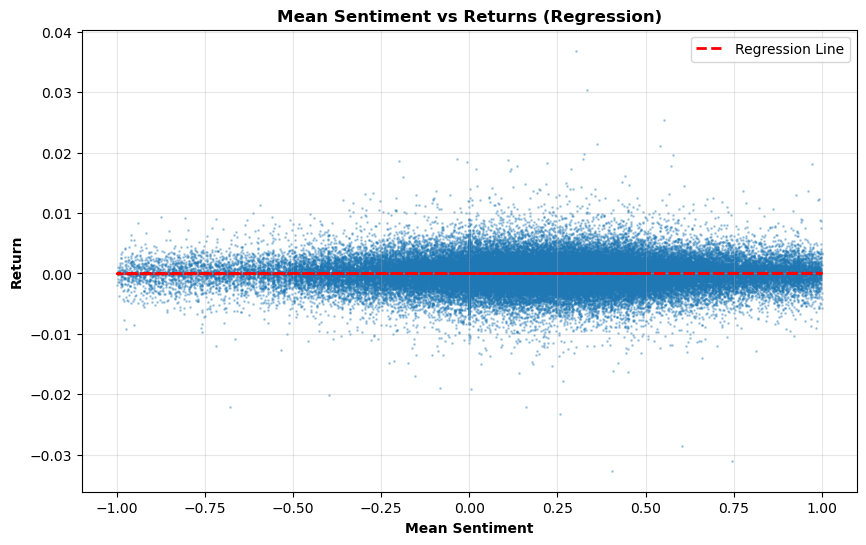

In [ ]:
df_reg2 = df[["mean_sent", "return"]].dropna()
if len(df_reg2) > 0:
    df_reg2 = df_reg2.rename(columns={'return': 'btc_return'})
    model2 = smf.ols('btc_return ~ mean_sent', data=df_reg2).fit()
    print(model2.summary())
    
    # Plot regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(df_reg2["mean_sent"], df_reg2["btc_return"], alpha=0.3, s=1)
    plt.plot(df_reg2["mean_sent"], model2.fittedvalues, 'r--', linewidth=2, label='Regression Line')
    plt.xlabel("Mean Sentiment", fontweight='bold')
    plt.ylabel("Return", fontweight='bold')
    plt.title("Mean Sentiment vs Returns (Regression)", fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Insufficient data for regression")


**Interpretation:** 
The graph is around zero for all sentiment values from -1 to +1, thus there’s no visible pattern of higher or lower returns with sentiment. The regression line is essentially flat at zero, indicating no linear relationship.

From this, we can conclude that the mean sentiment doesn’t explain or predict returns, they stay near zero regardless of sentiment level.

## Sentiment byt ime of day / day of the week analysis

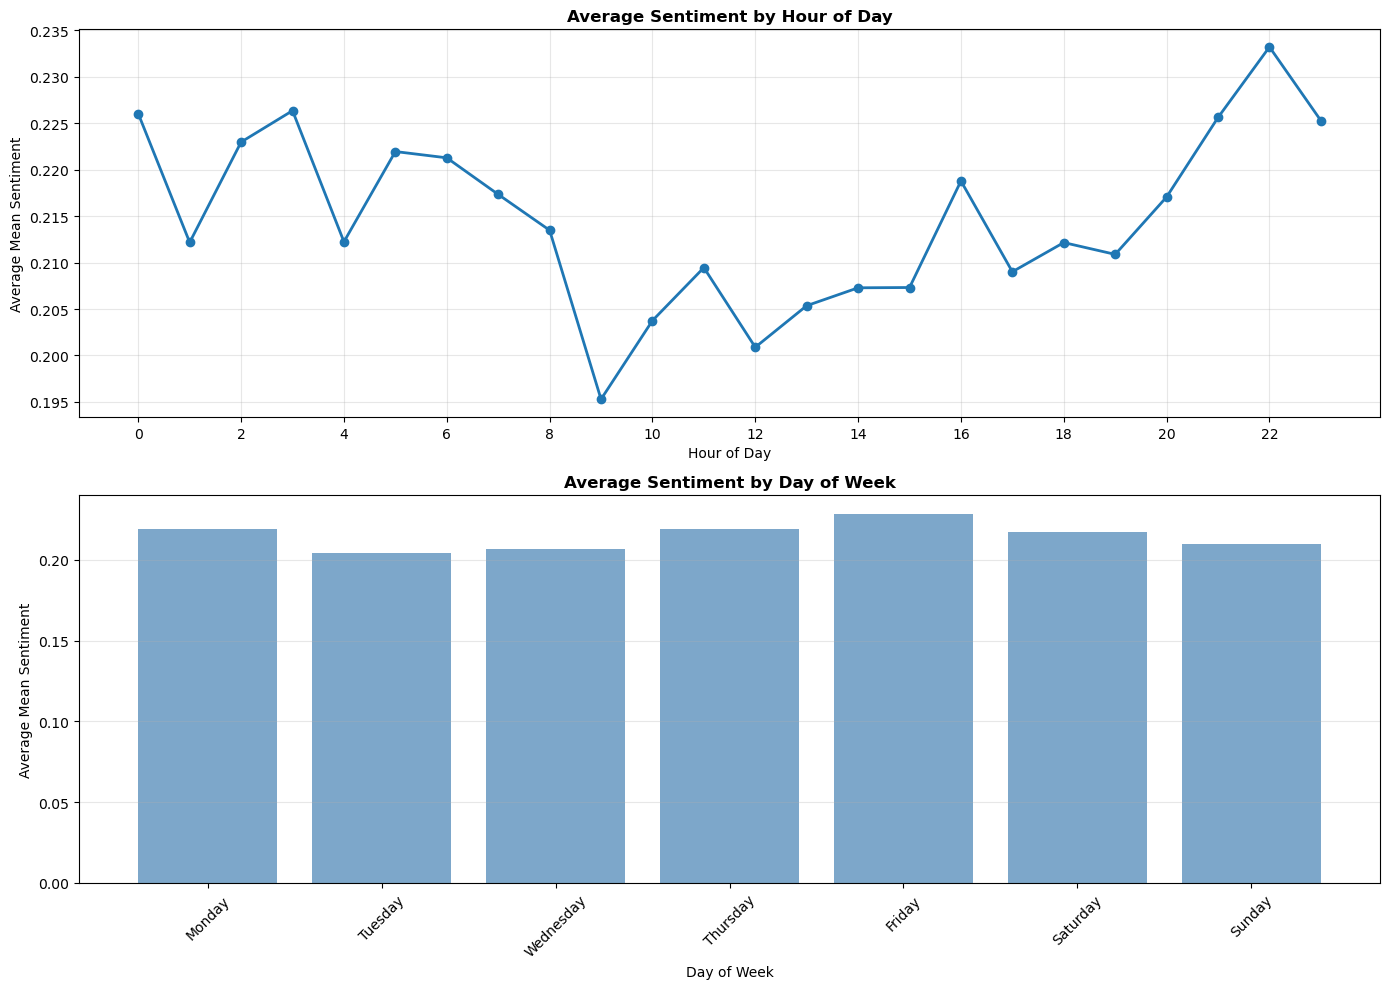

In [ ]:
df["minute"] = pd.to_datetime(df["minute"], errors="coerce")
df["hour"] = df["minute"].dt.hour
df["day_of_week"] = df["minute"].dt.day_name()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Average sentiment by hour
hourly_sentiment = df.groupby("hour")["mean_sent"].mean()
axes[0].plot(hourly_sentiment.index, hourly_sentiment.values, marker='o', linewidth=2, markersize=6)
axes[0].set_title("Average Sentiment by Hour of Day", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Average Mean Sentiment")
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

# Average sentiment by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sentiment = df.groupby("day_of_week")["mean_sent"].mean().reindex(day_order)
axes[1].bar(daily_sentiment.index, daily_sentiment.values, color='steelblue', alpha=0.7)
axes[1].set_title("Average Sentiment by Day of Week", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Day of Week")
axes[1].set_ylabel("Average Mean Sentiment")
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


- by hour: sentiment hovers around ~0.20-0.23 all day. Slight dip mid-morning (around 9-12) and slight peaks near midnight and late evening, but differences are tiny

- by day: sentiment is very similar across wekdays and weekend (~0.20-0.22). Friday is a hair higher; Monday/Saturday close behind; Tuesday/Sunday a touch lower. Overall variation is minimal

We can conclude that the sentiment is broadly stable by hour and by day, with only small changes

## Summary statistics

In [14]:

datasets = {
    "train1": train1_merged,
    "train2": train2_merged,
    "train3": train3_merged,
    "train4": train4_merged,
    "validate": validate_merged,
    "test": test_merged
}

summary_stats = []
for name, dataset in datasets.items():
    ds = dataset.copy()
    ds["return"] = ds["close"].pct_change()
    ds["volatility"] = ds["return"].rolling(window=60).std()
    ds_clean = ds[["mean_sent", "return", "volatility"]].dropna()
    
    if len(ds_clean) > 0:
        summary_stats.append({
            "Dataset": name,
            "Minutes": len(ds),
            "Mean Sentiment": ds_clean["mean_sent"].mean(),
            "Sentiment Std": ds_clean["mean_sent"].std(),
            "Avg Return": ds_clean["return"].mean(),
            "Avg Volatility": ds_clean["volatility"].mean(),
            "Sent-Return Corr": ds_clean[["mean_sent", "return"]].corr().iloc[0,1],
            "Sent-Vol Corr": ds_clean[["mean_sent", "volatility"]].corr().iloc[0,1]
        })

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))


 Dataset  Minutes  Mean Sentiment  Sentiment Std    Avg Return  Avg Volatility  Sent-Return Corr  Sent-Vol Corr
  train1    81372        0.214908       0.361677 -1.897300e-07        0.002242          0.005341      -0.022815
  train2    70780        0.198008       0.438414 -1.130376e-06        0.001448          0.002671      -0.010377
  train3    64971        0.209591       0.462902 -4.840429e-06        0.001069          0.004270      -0.003535
  train4    60558        0.199374       0.478556  2.411793e-06        0.000948          0.003062      -0.006531
validate    53216        0.195874       0.494161 -1.738363e-06        0.000671          0.008412      -0.015855
    test    59326        0.173635       0.478898 -7.391491e-06        0.001385         -0.002326      -0.003023


**Interpretation:** This summary table provides a comparative view across all datasets (train1-4, validate, test). The Sent-Vol Corr column directly answers RQ2 for each dataset. 

- sentiment levels: mean sentiment is mildly positive (≈0.17–0.21) in every split; variability (std ~0.36–0.49) is similar across splits.
- returns: average returns are essentially zero in all splits (tiny positives/negatives).
- volatility: average volatility stays low across splits (around 0.001–0.002, except validate higher at ~0.0084).
- correlations: sentiment vs returns and sentiment vs volatility are near zero (from about -0.02 to -0.003), meaning no meaningful linear relationship in any split.

RQ2 Answer: Based on the correlation values shown (all between -0.023 and -0.002), we can conclude that reddit sentiment does NOT meaningfully correlate with Bitcoin volatility in short time intervals. The correlations are too weak to be considered meaningful, and the consistency across all datasets provides strong evidence for this conclusion.
